# Cloverleaf Bridge

## 0. Imports

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

## 1. Dataset and Preprocessing

### 1.1 Image Loading and Exploration

Dimension: (1207, 1207, 3)
Pixel value range: [0, 253]


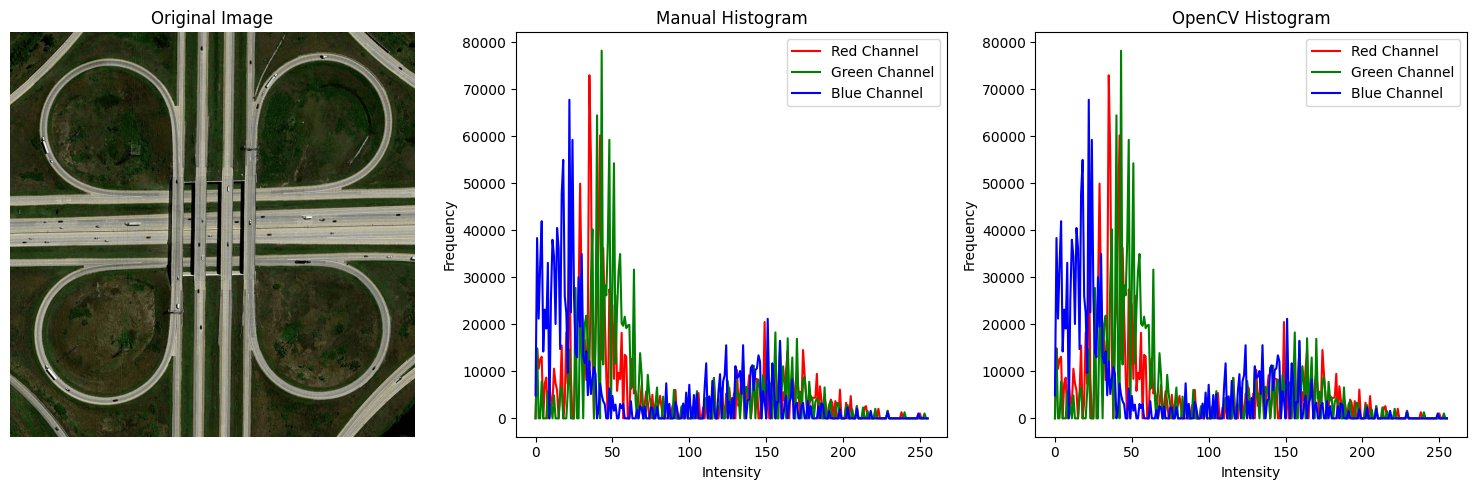

In [2]:
def load_cloverleaf_image(image_path):
    """ Loads the cloverleaf bridge image and prints image characteristics. """

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    hist_manual = [
        np.bincount(image[:, :, 0].ravel(), minlength=256),
        np.bincount(image[:, :, 1].ravel(), minlength=256),
        np.bincount(image[:, :, 2].ravel(), minlength=256)
    ]
    hist_opencv = [
        cv2.calcHist([image], [0], None, [256], [0, 255]),
        cv2.calcHist([image], [1], None, [256], [0, 255]),
        cv2.calcHist([image], [2], None, [256], [0, 255]),
    ]

    print(f'Dimension: {image.shape}')
    print(f'Pixel value range: [{image.min()}, {image.max()}]')

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(image)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].plot(hist_manual[0], c='r', label='Red Channel')
    axs[1].plot(hist_manual[1], c='g', label='Green Channel')
    axs[1].plot(hist_manual[2], c='b', label='Blue Channel')
    axs[1].set_ylabel('Frequency')
    axs[1].set_xlabel('Intensity')
    axs[1].legend()
    axs[1].set_title('Manual Histogram')

    axs[2].plot(hist_opencv[0], c='r', label='Red Channel')
    axs[2].plot(hist_opencv[1], c='g', label='Green Channel')
    axs[2].plot(hist_opencv[2], c='b', label='Blue Channel')
    axs[2].set_ylabel('Frequency')
    axs[2].set_xlabel('Intensity')
    axs[2].legend()
    axs[2].set_title('OpenCV Histogram')

    plt.tight_layout()
    plt.savefig('load_cloverleaf_image.png', bbox_inches='tight')
    plt.show()

    return image

image = load_cloverleaf_image('../data/cloverleaf_interchange.png')

### 1.2 Image Preprocessing

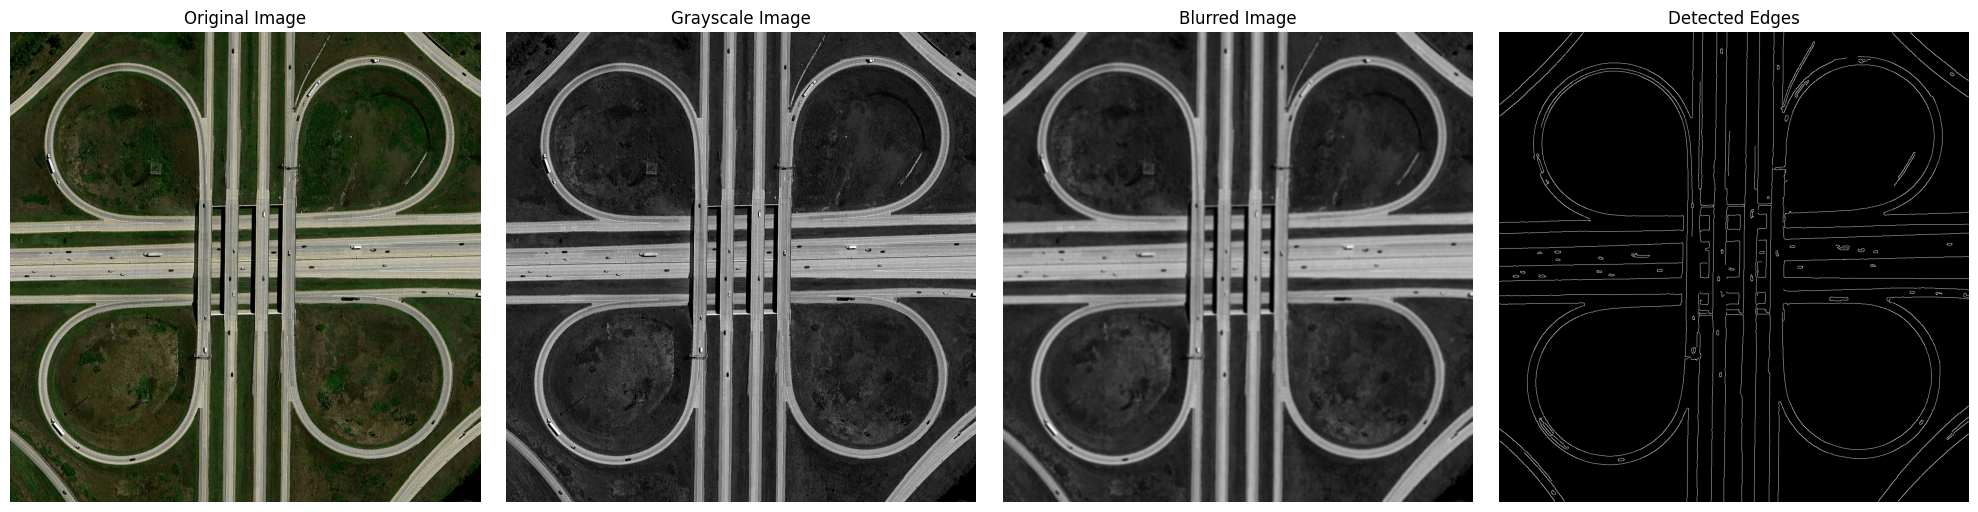

In [3]:
def preprocess_image(image):
    """ Preprocessing for circle detection in the cloverleaf bridge image. """

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (11, 11), 0)
    edges = cv2.Canny(blurred, 50, 150)

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    axs[0].imshow(image)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(gray, cmap='gray')
    axs[1].set_title('Grayscale Image')
    axs[1].axis('off')

    axs[2].imshow(blurred, cmap='gray')
    axs[2].set_title('Blurred Image')
    axs[2].axis('off')

    axs[3].imshow(edges, cmap='gray')
    axs[3].set_title('Detected Edges')
    axs[3].axis('off')

    plt.tight_layout()
    plt.savefig('preprocess_image.png', bbox_inches='tight')
    plt.show()

    return edges

edges = preprocess_image(image)

**Comments:**

- Grayscale Conversion: We will later be using Hough Transform for Circles, which requires image to be grayscale. Note that the color image is dominated by green, which will be preserved to a good extent during grayscale conversion.

- Gaussian Blur: This helps us get cleaner edges, that highlight the pathways (also vehicles) and not the less interesting variations.

- Canny Edges: Looking at edges make it easier to detect shapes, including circles. Although CV2's function for Hough Transform does edge detection automatically, I did it manually for illustration.

## 2. Cloverleaf Detection and Measurement

### 2.1 Cloverleaf Detection and Visualization

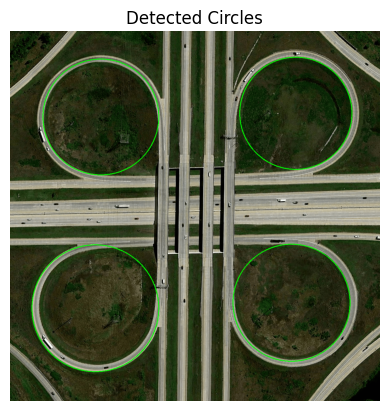

In [4]:
def detect_cloverleaves(image, edges):
    """ Circle detection in the cloverleaf bridge image. """

    output = image.copy()
    circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1, minDist=450, param1=50, param2=50, minRadius=100, maxRadius=230)
    circles = np.uint16(np.around(circles))[0]
    for circle in circles:
        cv2.circle(output, (circle[0], circle[1]), circle[2], (0, 255, 0), 2)

    plt.imshow(output)
    plt.title('Detected Circles')
    plt.axis('off')
    plt.savefig('detect_cloverleaves.png', bbox_inches='tight')
    plt.show()

detect_cloverleaves(image, edges)

**Comments:**

- Impact of preprocessing: The preprocessing choices ensure that only straight roads and circular cloverleaves are visible. That leaves less room for error.

- Parameter choices: Hough Transform for circles detects circles in the (x, y, r) parameter space. It depends on the threshold to be applied on the accumulated value, besides acceptable range for radius and distance to other centres (in the case of CV2 implementation). The right thresholds can vary from image to image depending on the expected output. We may at times desire (subjectivity) an output that is not very sensible algorithmically.

- Possible cases of failure: Note that the clover where approximated to be circles. This approach can clearly fail when the approximation gets weaker (think of it as looking more like a petal). It is also likely to fail when the circles are of varying radii. In that case, it will be very difficult to set an acceptable range for radius, and filter outliers.

### 2.2 Measuring the Radii of the Detected Cloverleaves

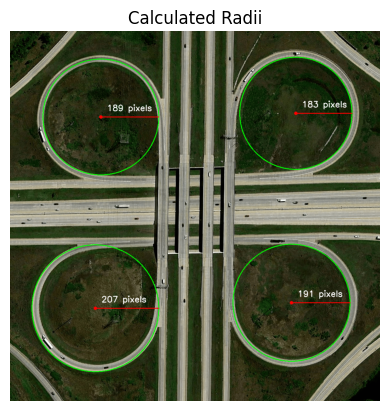

Radii (in pixels): [183, 189, 207, 191]


In [5]:
def calculate_radii(image, edges):
    """ Calculates radius of circles in the cloverleaf bridge image. """

    output = image.copy()
    circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1, minDist=450, param1=50, param2=50, minRadius=100, maxRadius=230)
    circles = np.uint16(np.around(circles))[0]
    for circle in circles:
        cv2.circle(output, (circle[0], circle[1]), circle[2], (0, 255, 0), 2)
        cv2.circle(output, (circle[0], circle[1]), 3, (255, 0, 0), 3)
        cv2.line(output, (circle[0], circle[1]), (circle[0] + circle[2], circle[1]), (255, 0, 0), 2)
        cv2.putText(output, f'{circle[2]} pixels', (circle[0] + 20, circle[1] - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)

    plt.imshow(output)
    plt.title('Calculated Radii')
    plt.axis('off')
    plt.savefig('calculate_radii.png', bbox_inches='tight')
    plt.show()

    radii = [int(circle[2]) for circle in circles]
    print('Radii (in pixels):', radii)

    return radii, circles

radii, circles = calculate_radii(image, edges)

**Comments:**

- The method chosen characterizes the detected circles by their radii (and centres). Thus, the radii need not be computed separately after circle detection.

- A source of error here is the presence of concentric circles. Tweaking CV2's radius range (for some reason) fails to address this issue. One tempting solution is to use hit or miss transform to detect circles of the right size but that would require the cloverleaves to be exactly circular, besides having the exact value of the radii.

### 2.3 Approximating the Area Enclosed by Each Cloverleaf

In [6]:
def calculate_area(image, circles, radii):
    """ Calculates areas of circles in the cloverleaf bridge image. """

    areas_circle = []
    for radius in radii:
        areas_circle.append(round(np.pi * (radius ** 2), 2))

    areas_counting = []
    for circle in circles:
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        cv2.circle(mask, (circle[0], circle[1]), circle[2], (255, 255, 255), -1)
        areas_counting.append(int(np.bincount(mask.ravel(), minlength=256)[255]))

    print('Areas (in square pixels) using circle formula:', areas_circle)
    print('Areas (in square pixels) using pixel counting:', areas_counting)

calculate_area(image, circles, radii)

Areas (in square pixels) using circle formula: [105208.8, 112220.83, 134614.1, 114608.44]
Areas (in square pixels) using pixel counting: [105185, 112193, 134565, 114553]


**Comments:**

- Both the suggested methods produced approximately similar results. The percent error being as low as 0.025%.

- The pixel counting approach undercounts the area compared to formula based approach. This can be attributed to points being missed due to discretization.